# KNN bayes non-stratified sampler

In [53]:
import sys
import subprocess
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys

# from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns

sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
from pathlib import Path
import requests
import psutil
import random
import threading
import tracemalloc
import itertools
import math
import warnings
import sklearn.metrics as metrics
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys

# from geosketch import gs
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns

sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
from pathlib import Path
import requests
import psutil
import random
import threading
import tracemalloc
import itertools
import math
import warnings
import sklearn.metrics as metrics
import numpy as np
from sklearn.metrics import log_loss
import mygene
import gseapy as gp
import mygene
import scipy.sparse as sparse
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import pymc3 as pm
from scipy.sparse import csr_matrix
from scipy.stats import entropy
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import warnings


def Attention_based_KNN_sampling(
    adata,
    knn_key,
    sampling_rate=0.1,
    iterations=1,
    representation_priority=0.9,
    equal_allocation=False,
    replace=True,
    weight_penalty="laplacian_SGD_pagerank",
    pl_label_entropy=False,
    resample_clones=False,
    **kwargs
):
    # Unpack kwargs
    if kwargs:
        for key, value in kwargs.items():
            globals()[key] = value
        kwargs.update(locals())

    print("Non-stratified sampling based on attention weights chosen")

    if representation_priority > 0.8:
        print(
            "warning: you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states"
        )
        warnings.warn(
            "warning you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states"
        )

    neighborhood_matrix = adata.obsp[adata.uns[knn_key]["connectivities_key"]]
    # Calculate total sample size and sample size per label for equal allocation
    total_sample_size = int(sampling_rate * adata.shape[0])
    #     sample_size_per_label = total_sample_size // len(unique_labels)

    if (
        weight_penalty == "laplacian_SGD_pagerank"
    ):  # This is essentially an attention score
        print(
            "Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank"
        )
        # This is essentially the calculation of the Laplacian of the graph.
        # Calculate degrees
        degrees = (
            np.array(neighborhood_matrix.sum(axis=1)).flatten() + 1
        )  # this is a generalization of the concept of degree for weighted graphs
        # Calculate inverse square root of degrees
        inv_sqrt_degrees = 1 / np.sqrt(degrees)
        # Create diagonal matrix of inverse square root degrees
        inv_sqrt_deg_matrix = scipy.sparse.diags(inv_sqrt_degrees)
        # Apply transformation to the adjacency matrix
        normalized_matrix = (
            inv_sqrt_deg_matrix @ neighborhood_matrix @ inv_sqrt_deg_matrix
        )
        #     # Now you can use normalized_matrix in place of neighborhood_matrix
        #     attention_score = normalized_matrix[indices].sum(axis = 1)
        # Convert your sparse matrix to a csr_matrix if it's not already
        csr_matrix = normalized_matrix.tocsr()
        attention_scores, l2_norm_dic = SGDpagerank(
            csr_matrix,
            num_iterations=1000,
            sampling_method="probability_based",
            mini_batch_size=1000,
            initial_learning_rate=0.85,
            tolerance=1e-6,
            d=0.85,
            full_batch_update_iters=100,
        )

    print("proceeding to 2 stage sampling using attention scores as priors")
    # Add the attention scores to the observation dataframe
    adata.obs["sf_attention"] = attention_scores

    # Iterate over each unique stratifying variable
    # for n in adata.obs[strat_var].unique():
    tmp_obs = adata.obs  # [adata.obs[strat_var] == n]
    indices = range(len(tmp_obs))
    attention_scores_tmp = tmp_obs["sf_attention"]

    # Apply softmax to attention scores
    e_v = np.exp(attention_scores_tmp - np.max(attention_scores_tmp))
    sf_attention = e_v / e_v.sum()

    # Calculate total sample size
    total_sample_size = int(sampling_rate * len(tmp_obs))

    # Initialize list to store all sampled indices
    all_sampled_indices = []

    # Conduct sampling N times (100 by default)
    N = 100
    for i in range(N):
        sampled_indices = np.random.choice(
            indices, size=total_sample_size, replace=False, p=sf_attention
        )
        all_sampled_indices.extend(sampled_indices)

    # Count the frequency of each index
    index_freq = Counter(all_sampled_indices)

    # Convert the frequencies to probabilities
    total_samples = sum(index_freq.values())
    sampling_probabilities = {
        index: freq / total_samples for index, freq in index_freq.items()
    }

    # Convert dictionary keys and values to lists for sampling
    sample_indices = list(sampling_probabilities.keys())
    sample_probs = list(sampling_probabilities.values())

    sampled_indices_from_output = np.random.choice(
        sample_indices, size=total_sample_size, p=sample_probs, replace=False
    )

    adata_samp = adata[sampled_indices_from_output]
    print("Sampling complete!")

    return adata_samp, sample_probs, attention_scores

In [ ]:
import scanpy as sc
import scentinel as scent

adata = sc.read(
    "/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_data/Submission_2_data/A2_V10_scvi_YS_integrated/A2_V10_qc_raw_obsm.h5ad"
)

Non-stratified sampling based on attention weights chosen
Using Laplacian-SGD-Pagerank penalty term, this is similar in concept to an attention score in GANs but incorperates stochastic gradient descent version of pagerank


/tmp/ipykernel_19537/2011646558.py:93: UserWarning: warning you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states
  warnings.warn('warning you have set a very high prioritisation factor, this will heavily bias the sampling of under-represented states')


Converged at iteration 745
Proceeding on to perform fine-tuning across full-batch


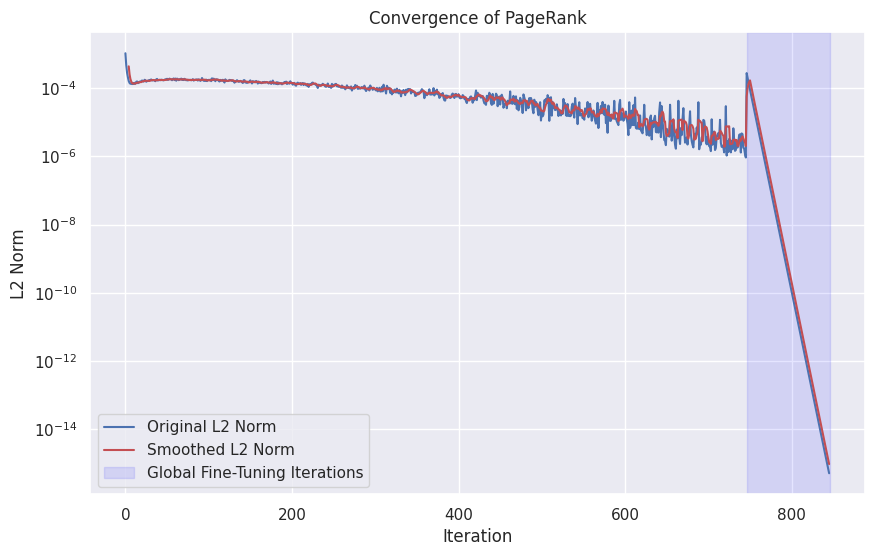

You should observe one dip in the graph, the first post initialisation and a continual trend downwards as the model learns more structure in your data
Erratic behavious post this initial dip should trend downwards. This shows that as the model visits more nodes, we see gradual model improvement
proceeding to 2 stage sampling using attention scores as priors


In [54]:
adata_samp, sample_probs, attention_scores = Attention_based_KNN_sampling(
    adata,
    knn_key="neighbors",
    sampling_rate=0.1,
    iterations=1,
    representation_priority=0.9,
    equal_allocation=False,
    replace=True,
    weight_penalty="laplacian_SGD_pagerank",
    pl_label_entropy=False,
    resample_clones=False,
)

In [55]:
adata_samp

View of AnnData object with n_obs × n_vars = 16949 × 37318
    obs: 'file', 'name', 'uniform_label', 'uniform_label_expanded_merged', 'uniform_label_lvl0', 'organ', 'Sample.lanes', 'Sort_id', 'age', 'method', 'donor', 'sex', 'Processing_method', 'AnnatomicalPart', 'Sample', 'anno_lvl_2_final_clean', 'celltype_annotation', 'cell.labels', 'stage', 'lanes', 'sort.ids', 'fetal.ids', 'component', 'broad_cell.labels', 'sequencing.type', 'orig.dataset', 'broad_cell_labels_organ', 'tissue', 'V6_old_indexes', 'dataset_merge', 'index_orig', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'new_data_handle', 'batch', 'HDBR_ID', 'leiden_scvi_res15', 'num', 'cell.labels_num', 'leiden_scvi_res15_num', 'clus_prediction', 'clus_prediction_num', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'restricted_leiden_scvi_res15', 'umap_density_clus_prediction', 'umap_density_clus_prediction_AEC', 'cell.labels_v2_num', 'scrublet_score', 'scrublet_cluster_score', 'scr_bh_pva

In [22]:
adata.obs["patient_tum"] = (
    adata.obs["patient"].astype(str) + "_" + adata.obs["tum.norm"].astype(str)
)
strat_var = "patient_tum"
adata.obs["sf_attention"] = attention_scores
index_set = []
total_set_n = 100
sample_dic = {}
import anndata
import numpy as np
from collections import Counter

import anndata
import numpy as np
from collections import Counter


def create_pseudobulk(adata, strat_var, attention_scores, total_set_n=100):
    # Initialize the sample dictionary
    sample_dic = {}

    # Initialize a list to store the pseudobulk matrices and strat_var values
    pseudobulk_list = []
    strat_var_list = []
    patient_list = []
    risk_stat_list = []

    # Add the attention scores to the observation dataframe
    adata.obs["sf_attention"] = attention_scores

    # Iterate over each unique stratifying variable
    for n in adata.obs[strat_var].unique():
        tmp_obs = adata.obs[adata.obs[strat_var] == n]
        indices = range(len(tmp_obs))
        attention_scores_tmp = tmp_obs["sf_attention"]

        # Apply softmax to attention scores
        e_v = np.exp(attention_scores_tmp - np.max(attention_scores_tmp))
        sf_attention = e_v / e_v.sum()

        # Calculate total sample size
        total_sample_size = int(0.1 * len(tmp_obs))

        # Initialize list to store all sampled indices
        all_sampled_indices = []

        # Conduct sampling N times (100 by default)
        N = 100
        for i in range(N):
            sampled_indices = np.random.choice(
                indices, size=total_sample_size, replace=False, p=sf_attention
            )
            all_sampled_indices.extend(sampled_indices)

        # Count the frequency of each index
        index_freq = Counter(all_sampled_indices)

        # Convert the frequencies to probabilities
        total_samples = sum(index_freq.values())
        sampling_probabilities = {
            index: freq / total_samples for index, freq in index_freq.items()
        }

        # Convert dictionary keys and values to lists for sampling
        sample_indices = list(sampling_probabilities.keys())
        sample_probs = list(sampling_probabilities.values())

        # Create pseudobulk for each set
        for pos in range(total_set_n):
            sampled_indices_from_output = np.random.choice(
                sample_indices, size=total_sample_size, p=sample_probs, replace=False
            )
            pseudobulk = np.mean(adata.X[sampled_indices_from_output, :], axis=0)
            pseudobulk_list.append(pseudobulk)

            # Add the strat_var value for this pseudobulk
            strat_var_list.append(n)
            patient_list.append(
                tmp_obs["patient"].iloc[0]
            )  # Assuming that 'patient' and 'risk_stat' are constant for each group defined by strat_var
            risk_stat_list.append(tmp_obs["risk_stat"].iloc[0])

            if n not in sample_dic:
                sample_dic[n] = []
            sample_dic[n].append(sampled_indices_from_output)

    # Convert the list of pseudobulk arrays into a single NumPy array
    pseudobulk_matrix = np.stack(pseudobulk_list)

    # Create an AnnData object to store the pseudobulk data
    pseudobulk_adata = anndata.AnnData(X=pseudobulk_matrix)

    # Add the strat_var to the .obs attribute of the output AnnData object
    pseudobulk_adata.obs[strat_var] = strat_var_list
    pseudobulk_adata.obs["patient"] = patient_list
    pseudobulk_adata.obs["risk_stat"] = risk_stat_list

    # Initialize a list to store the pseudobulk matrices and strat_var values

    return pseudobulk_adata, sample_dic


pseudobulk_adata, sample_dic = create_pseudobulk(
    adata, strat_var, attention_scores, total_set_n=100
)

KeyError: 'patient'

In [27]:
attention_scores = attention_score
total_set_n = 100
samp_frac = 0.1

In [51]:
# Initialize a list to store the pseudobulk matrices and strat_var values

# Add the attention scores to the observation dataframe
adata.obs["sf_attention"] = attention_scores

# Iterate over each unique stratifying variable
# for n in adata.obs[strat_var].unique():
tmp_obs = adata.obs  # [adata.obs[strat_var] == n]
indices = range(len(tmp_obs))
attention_scores_tmp = tmp_obs["sf_attention"]

# Apply softmax to attention scores
e_v = np.exp(attention_scores_tmp - np.max(attention_scores_tmp))
sf_attention = e_v / e_v.sum()

# Calculate total sample size
total_sample_size = int(samp_frac * len(tmp_obs))

# Initialize list to store all sampled indices
all_sampled_indices = []

# Conduct sampling N times (100 by default)
N = 100
for i in range(N):
    sampled_indices = np.random.choice(
        indices, size=total_sample_size, replace=False, p=sf_attention
    )
    all_sampled_indices.extend(sampled_indices)

# Count the frequency of each index
index_freq = Counter(all_sampled_indices)

# Convert the frequencies to probabilities
total_samples = sum(index_freq.values())
sampling_probabilities = {
    index: freq / total_samples for index, freq in index_freq.items()
}

# Convert dictionary keys and values to lists for sampling
sample_indices = list(sampling_probabilities.keys())
sample_probs = list(sampling_probabilities.values())

sampled_indices_from_output = np.random.choice(
    sample_indices, size=total_sample_size, p=sample_probs, replace=False
)

In [52]:
sampled_indices_from_output

array([120776,   6056,  23506, ..., 128823,  74961,  19892])

In [35]:
sampling_probabilities

{3125: 6.4900584105256945e-06,
 111899: 5.900053100477905e-06,
 166519: 3.5400318602867426e-06,
 87974: 7.080063720573485e-06,
 162512: 6.4900584105256945e-06,
 24037: 7.670069030621276e-06,
 51538: 7.670069030621276e-06,
 107014: 7.080063720573485e-06,
 93695: 4.130037170334533e-06,
 6302: 4.720042480382323e-06,
 63732: 6.4900584105256945e-06,
 99683: 5.900053100477905e-06,
 34042: 7.670069030621276e-06,
 152460: 6.4900584105256945e-06,
 10760: 5.310047790430114e-06,
 49174: 8.260074340669067e-06,
 15257: 7.080063720573485e-06,
 119118: 6.4900584105256945e-06,
 11801: 5.310047790430114e-06,
 66601: 5.900053100477905e-06,
 163447: 8.260074340669067e-06,
 8240: 7.080063720573485e-06,
 114213: 6.4900584105256945e-06,
 151068: 1.1210100890908019e-05,
 109009: 8.850079650716856e-06,
 57840: 6.4900584105256945e-06,
 116273: 5.310047790430114e-06,
 26010: 5.310047790430114e-06,
 111537: 4.130037170334533e-06,
 53540: 7.670069030621276e-06,
 60026: 8.850079650716856e-06,
 165755: 6.4900584105